# instructions

use fastpitch conda env
```bash
conda activate fastpitch
cd rlspeller/
./jupyter_lab.sh
```

In [1]:
docstring = """
(Use fastpitch conda env)

Helper script that takes a folder of speech reps (wav2vec2, mel-spec, etc.)
and aligns them at word-level using MFA alignments.

Speech reps corresponding to word tokens in the corpus are then saved individually to an output folder
with the following structure:
- data_path
    - word1
        - word1_LJ010-0292_001.pt
        - word1_LJ010-0292_002.pt
        - ...
    - word2
        - word2_LJ001-0012_001.pt
        - word2_LJ002-0024_001.pt
        - ...
    - ...

- word1, word2, ... subfolders refer to a particular wordtype in the corpus.
- .pt files contain speech representations that map to a particular example of a wordtype.
  It is named as:
    <wordtype>_<utt id>_<numbered occurrence in the utterance>.pt

Example usage:
    #hubert w/ padding offset
    cd ~/fairseq
    python examples/lexicon_learner/wordalign_speechreps.py \
        -t hubert \
        --padding_idx_offset 1 \
        -s /home/s1785140/fairseq/examples/lexicon_learner/lj_speech_quantized.txt \
        -a /home/s1785140/data/ljspeech_MFA_alignments \
        -o /home/s1785140/data/ljspeech_hubert_reps/hubert-base/layer-6/word_level_with_padding_idx_offset

    #hubert w/o padding offset
    cd ~/fairseq
    python examples/lexicon_learner/wordalign_speechreps.py \
        -t hubert \
        --padding_idx_offset 0 \
        -s /home/s1785140/fairseq/examples/lexicon_learner/lj_speech_quantized.txt \
        -a /home/s1785140/data/ljspeech_MFA_alignments \
        -o /home/s1785140/data/ljspeech_hubert_reps/hubert-base/layer-6/word_level_without_padding_idx_offset

    #wav2vec2
    cd ~/fairseq
    python examples/lexicon_learner/wordalign_speechreps.py \
        -t wav2vec2 \
        -s /home/s1785140/data/ljspeech_wav2vec2_reps/wav2vec2-large-960h/layer-15/utt_level \
        -a /home/s1785140/data/ljspeech_MFA_alignments \
        -o /home/s1785140/data/ljspeech_wav2vec2_reps/wav2vec2-large-960h/layer-15/word_level
"""

Command line args

In [2]:
# imitate CLAs
import sys

cla_dict = {
    "fastpitch": [
        'train.py',
        '--type', 'mel',
        '--utt_id_list', '/home/s1785140/data/ljspeech_fastpitch/respeller_uttids.txt', 
        '--input_directory', '/home/s1785140/data/ljspeech_fastpitch/mels',
        # '--alignments', '/home/s1785140/data/ljspeech_fastpitch/aligns', # older alignments (without using improved tokenizer)
        '--alignments', '/home/s1785140/speechbrain/templates/speech_recognition_CharTokens_NoLM/data/LJSpeech-1.1/MFA_alignments_lowercase_nopunc', # newer alignments, lowercase no punctuation
        '--output_directory', '/home/s1785140/data/ljspeech_fastpitch/wordaligned_mels_lowercase_nopunc',
        '--clean-output-folder',
#         '--max-utts-to-generate', '5', # for testing!!!
    ],
    "speechbrain": [
        'train.py',
        '--type', 'wav',
        '--utt_id_list', '/home/s1785140/data/ljspeech_fastpitch/respeller_uttids.txt', 
        '--input_directory', '/home/s1785140/speechbrain/templates/speech_recognition_CharTokens_NoLM/data/LJSpeech-1.1/wavs_16khz',
        '--alignments', '/home/s1785140/speechbrain/templates/speech_recognition_CharTokens_NoLM/data/LJSpeech-1.1/MFA_alignments_lowercase_nopunc', # newer alignments, lowercase no punctuation
        '--output_directory', '/home/s1785140/speechbrain/templates/speech_recognition_CharTokens_NoLM/data/ljspeech_wavs_16khz_word_aligned',
        # '--clean-output-folder',
        # '--max-utts-to-generate', '100', # for testing!!!
    ],
}

sys.argv = cla_dict["fastpitch"]

# imports and globals

In [3]:
import os
import argparse
import torch
from tqdm import tqdm
from collections import Counter
import numpy as np
import tgt
import string
import librosa
import glob
import random
from IPython.display import Audio
import nltk
from nltk.corpus import stopwords
import math
import shutil
# nltk.download('stopwords')

SKIP_NON_ASCII = False
WORDS_TO_SKIP = ["wdsu-tv"]

# Parser

In [4]:
parser = argparse.ArgumentParser()
parser.add_argument('-t', '--type', type=str, default='hubert',
                    help='type of input speech reps that we are using, i.e. hubert wav2vec2 etc.')
parser.add_argument('--padding_idx_offset', type=int, default=0,
                    help='add 1 to token id of discrete reps in order to allow for padding_idx==0')
parser.add_argument('--utt_id_list', type=str, required=False, default="",
                    help='path to text file that contains list of utterance ids that we extract from')
parser.add_argument('-s', '--input_directory', type=str, required=True,
                    help='path to single non-nested folder containing speech representations (.pt files) or txt file (hubert)')
parser.add_argument('-a', '--alignments', type=str, required=True,
                    help='path to single non-nested folder containing MFA alignments (.TextGrid files)')
parser.add_argument('-o', '--output_directory', type=str, required=True,
                    help='where to write word-level data')
parser.add_argument('--max-utts-to-generate', type=int, default=None,
                    help='How many utts to extract word aligned speech reps for. If None, extract all utts.')
parser.add_argument('--mel-to-graphemes-ratio-lowest-threshold', type=float, default=0.0,
                    help='Lowest mel-to-graphemes ratio to consider. (lower ratio means fewer mel frames per grapheme)')
parser.add_argument('--mel-to-graphemes-ratio-highest-threshold', type=float, default=math.inf,
                    help='Lowest mel-to-graphemes ratio to consider. (higher ratio means more mel frames per grapheme)')
parser.add_argument('--clean-output-folder', action="store_true",
                    help='Clean output folder before writing new data')
args = parser.parse_args()

if "speechbrain" in args.input_directory:
    args.corpus_name = "speechbrain"
    args.transpose_mel = False
    SAMPLING_RATE = 16000 # hz
    HOP_LENGTH_IN_MS = 10 # in ms
    WIN_LENGTH_IN_MS = 25 # in ms
    HOP_LENGTH = int(HOP_LENGTH_IN_MS * SAMPLING_RATE / 1000) # convert HOP_LENGTH to samples
    WIN_LENGTH = int(WIN_LENGTH_IN_MS * SAMPLING_RATE / 1000) # convert WIN_LENGTH to samples
elif "ljspeech" in args.input_directory:
    args.corpus_name = "ljspeech"
    args.transpose_mel = True
    SAMPLING_RATE = 22050 # hz
    HOP_LENGTH_IN_MS = 10 # in ms
    WIN_LENGTH_IN_MS = 25 # in ms
    HOP_LENGTH = int(HOP_LENGTH_IN_MS * SAMPLING_RATE / 1000) # convert HOP_LENGTH to samples
    WIN_LENGTH = int(WIN_LENGTH_IN_MS * SAMPLING_RATE / 1000) # convert WIN_LENGTH to samples

## sanity check alignments by generating wordaligned spectrograms using griffin-lim

In [7]:
# grab all mels and words in the output directory

# glob pytorch tensors from nested folders in output directory
# mel_paths = glob.glob(f'{args.output_directory}/**/*.pt', recursive=True)

wordtype = "secrete"
mel_paths = glob.glob(f'{args.output_directory}/{wordtype}/*.pt', recursive=True)

MAX_NUM = 10

# load mels into list
mels = []
words = []
for mel_path in tqdm(mel_paths[:MAX_NUM]):
    mel = torch.load(mel_path)
    mels.append(mel)

    # also get word from path
    word = mel_path.split('/')[-2]
    words.append(word)

tuples = list(zip(mels, words))
print(len(tuples))

100%|█████████████████████████████████████████████████████| 2/2 [00:00<00:00, 1399.27it/s]

2


In [8]:
def griffin_lim_synthesise(mel, n_iter=100):
    """Synthesises audio from mel spectrogram using Griffin-Lim algorithm.
    Args:
        mel (torch.Tensor): Mel spectrogram (B, C, T).
        n_iter (int): Number of iterations for Griffin-Lim algorithm.
    Returns:
        torch.Tensor: Audio waveform (B, T).
    """
    mel = mel.detach().cpu().numpy()
    mel = librosa.feature.inverse.mel_to_audio(
        mel, sr=SAMPLING_RATE, n_fft=1000, hop_length=HOP_LENGTH, win_length=WIN_LENGTH,
        window='hamming', center=True, pad_mode='constant', power=1.0, 
        n_iter=n_iter,
        )
    mel = torch.from_numpy(mel).float()
    return mel

def reshape_mel_for_librosa(mel):
    mel = mel.unsqueeze(0) # make batch dimension
    mel = mel.transpose(1, 2)
    return mel

def synthesise_and_play_Audio(mel, n_iter=100):
    mel = reshape_mel_for_librosa(mel)
    print(mel.shape)
    audio = griffin_lim_synthesise(mel, n_iter)
    return Audio(audio, rate=SAMPLING_RATE)

## listen to generated audio for each word

In [9]:
# NOTE these might sound very bad for two reasons
# 1. stft -> mel spec is not lossless
# 2. (speechbrain) ASR features are fewer bins (i.e. 40 rather than 80 mel spec bins)
# but still good enough for sanity checking alignments!


# generate wavs from mels and then concatenate them into a single wav separated by silences and play in notebook
# NOTE this is not lossless, but still good enough for sanity checking alignments!
def generate_wav_from_mel(mel, n_iter=100):
    mel = reshape_mel_for_librosa(mel)
    audio = griffin_lim_synthesise(mel, n_iter)
    audio = audio.squeeze(0)
    audio = audio.numpy()
    return audio

def generate_wav_from_mels_with_silences(mels, n_iter=100, silence_duration=0.5):
    wavs = []
    for mel in mels:
        wavs.append(generate_wav_from_mel(mel, n_iter))
        wavs.append(np.zeros(int(silence_duration * SAMPLING_RATE)))
    wav = np.concatenate(wavs)
    return wav

def generate_wav_from_mels_with_silences_and_play(mels, n_iter=100, silence_duration=0.5):
    wav = generate_wav_from_mels_with_silences(mels, n_iter, silence_duration)
    return Audio(wav, rate=SAMPLING_RATE)


In [15]:
import matplotlib.pyplot as plt
import librosa.display

# plot mel spectrogram
def plot_mel(mel):
    mel = mel.detach().cpu().numpy()
    mel = librosa.power_to_db(mel, ref=np.max)
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(mel, x_axis="time", y_axis="mel", sr=SAMPLING_RATE, hop_length=HOP_LENGTH)
    plt.colorbar(format="%+2.f dB")
    plt.show()

In [ ]:
from fastpitch import models as fastpitch_model

def load_vocoder(args, device):
    """Load HiFi-GAN vocoder from checkpoint"""
    checkpoint_data = torch.load(args.hifigan)
    vocoder_config = fastpitch_model.get_model_config('HiFi-GAN', args)
    vocoder = fastpitch_model.get_model('HiFi-GAN', vocoder_config, device)
    vocoder.load_state_dict(checkpoint_data['generator'])
    vocoder.remove_weight_norm()
    vocoder.eval()
    return vocoder

vocoder = load_vocoder(args, device)

secrete
tensor([[ -6.3885,  -5.6114,  -5.0328,  ...,  -5.7186,  -6.0339,  -5.9477],
        [ -6.9023,  -6.2450,  -5.5079,  ...,  -4.3837,  -4.3223,  -4.8648],
        [ -9.3178,  -7.0049,  -5.5504,  ...,  -3.1397,  -3.1995,  -3.5578],
        ...,
        [ -7.8716,  -7.2103,  -6.9310,  ..., -10.2974, -10.3621, -10.0296],
        [ -8.4859,  -7.0208,  -6.5747,  ..., -10.4048, -10.4245, -10.2675],
        [ -8.0095,  -7.0117,  -6.8422,  ..., -10.2227, -10.6376, -10.6821]])


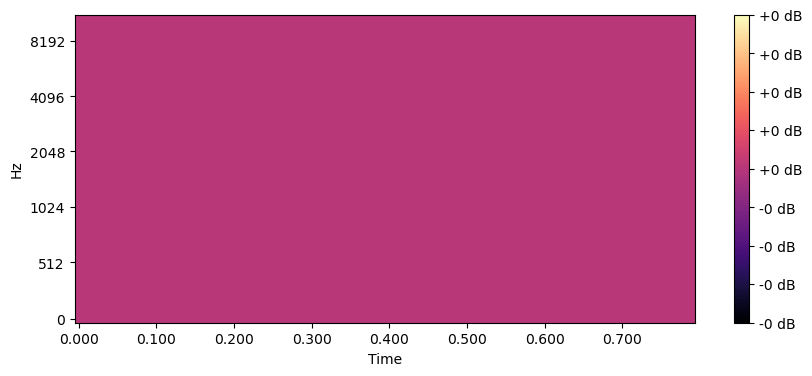

torch.Size([1, 80, 49])


secrete
tensor([[ -8.0569,  -7.2965,  -6.5549,  ...,  -8.9195,  -9.1096,  -8.8437],
        [ -7.4986,  -7.3319,  -6.0000,  ...,  -5.1960,  -5.3320,  -5.2952],
        [ -7.1921,  -6.2792,  -5.7799,  ...,  -3.8230,  -3.3961,  -4.1982],
        ...,
        [-10.7512,  -7.1502,  -7.3660,  ...,  -7.9844,  -7.8760,  -8.4793],
        [ -7.6466,  -7.8447,  -6.7955,  ...,  -5.5041,  -5.6101,  -5.6321],
        [ -7.7908,  -7.1411,  -7.0233,  ...,  -5.3558,  -5.3907,  -5.7967]])


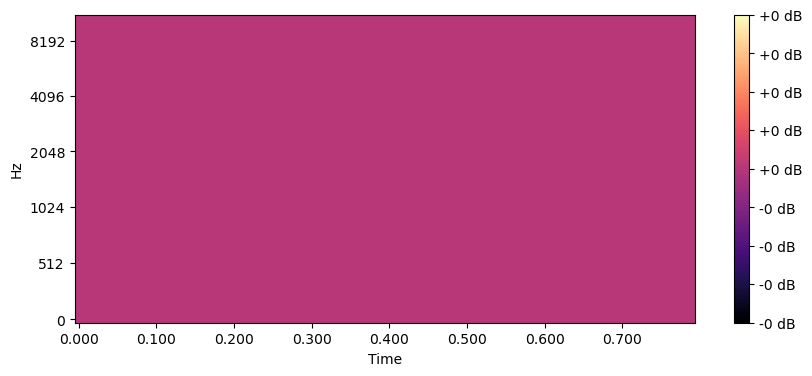

torch.Size([1, 80, 54])


In [16]:
NUM_TO_LISTEN = 10
# NUM_TO_LISTEN = 20

generate_all = True
generated_wordtypes = set()
skip_generated_wordtypes = True

if generate_all:
    # Generate all words in tuples
    mels_to_gen = [t[0] for t in tuples[:NUM_TO_LISTEN]]
    words_to_gen = [t[1] for t in tuples[:NUM_TO_LISTEN]]

    # sort mels and words by alphabetical order of words
    mels_to_gen, words_to_gen = zip(*sorted(zip(mels_to_gen, words_to_gen), key=lambda x: x[1]))

    for mel, word in zip(mels_to_gen, words_to_gen):
        if skip_generated_wordtypes and word in generated_wordtypes:
            continue
        else:
            print(word)
            print(mel)
            plot_mel(mel)
            display(synthesise_and_play_Audio(mel))

In [ ]:
generate_all = False
if generate_all:
    # Generate all words in tuples
    mels_to_gen = [t[0] for t in tuples[:NUM_TO_LISTEN]]
    words_to_gen = [t[1] for t in tuples[:NUM_TO_LISTEN]]

    # sort mels and words by alphabetical order of words
    mels_to_gen, words_to_gen = zip(*sorted(zip(mels_to_gen, words_to_gen), key=lambda x: x[1]))

    print("Generating audio for following words:", words_to_gen)
    generate_wav_from_mels_with_silences_and_play(mels_to_gen, silence_duration=0.4)

In [ ]:
raise ValueError("STOP after sanity check mels)

# Filter poor alignments

In [ ]:
""" filter out alignments based on certain criteria 
- where ratio of frames to graphemes is too low
- graphemes is too short

some problematic ones:
    - surpassed

from the below code, seems that mel-to-graphemes ratio of 
    - > 15.0 includes many examples of poor alignments
    - < 
"""

In [ ]:
# get mel to graphemes ratio for each word token
mel_to_graphemes_ratio = []
for mel, word in tqdm(tuples):
    mel_to_graphemes_ratio.append((mel, word, mel.shape[0] / len(word)))

# sort by ratio
mel_to_graphemes_ratio = sorted(mel_to_graphemes_ratio, key=lambda x: x[2])

NUM_TO_LISTEN = 30

# synthesise words with highest ratios (lowest to highest ratio)
mels_to_gen = [t[0] for t in mel_to_graphemes_ratio[-NUM_TO_LISTEN:]]
words_to_gen = [t[1] for t in mel_to_graphemes_ratio[-NUM_TO_LISTEN:]]
ratios = [t[2] for t in mel_to_graphemes_ratio[-NUM_TO_LISTEN:]]

print("Generating audio for following words:", list(zip(words_to_gen, ratios)))
generate_wav_from_mels_with_silences_and_play(mels_to_gen, silence_duration=0.4)

In [ ]:

# synthesise words with lowest ratios (lowest to highest ratio)
mels_to_gen = [t[0] for t in mel_to_graphemes_ratio[:NUM_TO_LISTEN]]
words_to_gen = [t[1] for t in mel_to_graphemes_ratio[:NUM_TO_LISTEN]]
ratios = [t[2] for t in mel_to_graphemes_ratio[:NUM_TO_LISTEN]]

print("Generating audio for following words:", list(zip(words_to_gen, ratios)))
generate_wav_from_mels_with_silences_and_play(mels_to_gen, silence_duration=0.4)


In [ ]:
# calculate mel to graphemes ratio threshold for bottom 5% and top 5%
# NOTE: this is not a good way to do this, since the distribution is not normal
# but it's good enough for now
bottom_5_percent = int(len(mel_to_graphemes_ratio) * 0.05)
top_5_percent = int(len(mel_to_graphemes_ratio) * 0.95)

bottom_5_percent_mel_to_graphemes_ratio = mel_to_graphemes_ratio[bottom_5_percent][2]
top_5_percent_mel_to_graphemes_ratio = mel_to_graphemes_ratio[top_5_percent][2]

print(f"{bottom_5_percent_mel_to_graphemes_ratio=}")
print(f"{top_5_percent_mel_to_graphemes_ratio=}")
print("Use these ratios to filter what speech reps get saved to disk!!!")

# filter out words with mel to graphemes ratio below threshold
# NOTE: this is not a good way to do this, since the distribution is not normal
# but it's good enough for now
mels_to_gen = [t[0] for t in mel_to_graphemes_ratio if t[2] > bottom_5_percent_mel_to_graphemes_ratio]
words_to_gen = [t[1] for t in mel_to_graphemes_ratio if t[2] > bottom_5_percent_mel_to_graphemes_ratio]
ratios = [t[2] for t in mel_to_graphemes_ratio if t[2] > bottom_5_percent_mel_to_graphemes_ratio]


In [ ]:
raise ValueError("stop before creating datasplits")

# create train,dev,test datasplits for training respeller

We hold out WORDTYPES from training for the dev and test splits

## Random

In [ ]:
import random
import json

random.seed(1337)

train_ratio, dev_ratio, test_ratio = [0.9, 0.05, 0.05]

In [ ]:
# get oov wordtypes list (words that are not seen in tts training)
oov_wordlist_path = '/home/s1785140/data/ljspeech_fastpitch/oov_list.json'
with open(oov_wordlist_path, 'r') as f:
    oovs_and_freqs = json.load(f)
    
all_wordtypes = set(oovs_and_freqs.keys())
print(f'original before cleaning/sampling {len(all_wordtypes)=}')

In [ ]:
# clean/remove words that do not have speech reps
words_with_aligned_mels = set(os.listdir(args.output_directory))
words_no_mels = all_wordtypes - words_with_aligned_mels
print(f'{len(words_no_mels)}=')

In [ ]:
print("list of words to be excluded from respeller training as they do not have mels (likely due to how normalisation is different between mfa and our own data processing):")
words_no_mels

In [ ]:
# sort

In [ ]:
# remove these problematic words from respeller training dev test
for w in words_no_mels:
    del oovs_and_freqs[w]
    
all_wordtypes = set(oovs_and_freqs.keys())
print(f'original after cleaning {len(all_wordtypes)=}')

dev_N = int(dev_ratio * len(all_wordtypes))
test_N = int(test_ratio * len(all_wordtypes))

In [ ]:
def sample_and_remove(s: set, N: int):
    """sample N words from set s
    then remove these words from the set"""
    sampled = random.sample(s, N)
    for item in sampled:
        s.remove(item)
    return set(sampled)

In [ ]:
#get dev and test splits
oov_singletons = set(wordtype for wordtype, freq in oovs_and_freqs.items() if freq == 1)
assert len(oov_singletons) > dev_N + test_N, "not enough OOV singletons to create dev and test sets" 
print(f'before sampling dev and test {len(oov_singletons)=}')

dev = sample_and_remove(oov_singletons, dev_N)
print(f'after sampling dev {len(oov_singletons)=}, {len(dev)=}')

test = sample_and_remove(oov_singletons, test_N)
print(f'after sampling test {len(oov_singletons)=}, {len(test)=}')

In [ ]:
list(dev)[:10]

In [ ]:
list(test)[:10]

In [ ]:
#get train split
print(f'before removing dev and test wordtypes {len(all_wordtypes)=}')
for word in dev | test:
    all_wordtypes.remove(word)
print(f'after removing dev and test wordtypes {len(all_wordtypes)=}')

train = set(all_wordtypes)

In [ ]:
# sanity checks
assert len(dev.intersection(test)) == 0
assert len(train.intersection(dev)) == 0
assert len(train.intersection(test)) == 0
print("Good! No overlapping words between train, dev, and test!!!")

In [ ]:
# write to disk
def save_wordlist(path, words):
    with open(path, 'w') as f:
        json.dump(sorted(list(words)), f, indent=4)
        
train_path = '/home/s1785140/data/ljspeech_fastpitch/respeller_train_words.json'
dev_path = '/home/s1785140/data/ljspeech_fastpitch/respeller_dev_words.json'
test_path = '/home/s1785140/data/ljspeech_fastpitch/respeller_test_words.json'

save_wordlist(train_path, train)
save_wordlist(dev_path, dev)
save_wordlist(test_path, test)

## G2P selection